In [ ]:
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm 

# Data
from keras.preprocessing.image import ImageDataGenerator

# Data Viz
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout

# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Transfer Learning Models
from tensorflow.keras.applications import ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Main Path
path = '/content/drive/MyDrive/data'

# Get Class Names
class_names = sorted(os.listdir(path))
n_classes = len(class_names)
print(f"Class Names: \n{class_names}")
print(f"Total Number of Classes : {n_classes}")

Class Names: 
['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Total Number of Classes : 10


In [ ]:
class_dis = [len(os.listdir(path + f"/{name}")) for name in class_names]
print(f"Class Distribution : \n{class_dis}")

Class Distribution : 
[323, 322, 323, 326, 323, 324, 321, 336, 327, 323]


In [ ]:
#Analyzing the distribution of dataset
fig = px.pie(names=class_names, values=class_dis, width=600)
fig.update_layout({"title":{'text':"Class Distribution","x":0.5}})
fig.show()

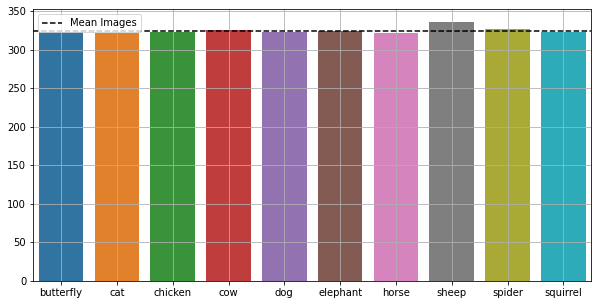

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=class_names, y=class_dis)
plt.grid()
plt.axhline(np.mean(class_dis), color='k', linestyle='--', label="Mean Images")
plt.legend()
plt.show()

In [ ]:
# Initialize Generator 
gen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=20, 
    validation_split=0.2)

# Load data
train_ds = gen.flow_from_directory(
    path, 
    target_size=(256,256), 
    class_mode='binary', 
    batch_size=32, 
    shuffle=True, 
    subset='training')

valid_ds = gen.flow_from_directory(
    path, 
    target_size=(256,256), 
    class_mode='binary', 
    batch_size=32, 
    shuffle=True, 
    subset='validation')

Found 2603 images belonging to 10 classes.
Found 645 images belonging to 10 classes.


In [ ]:
def show_image(img, title=None):
    '''The function takes in a Image and plots it'''
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

In [ ]:
def get_random_data(data):
    images, labels = data
    id = np.random.randint(len(images))
    image, label = images[id], labels[id]
    return image, label

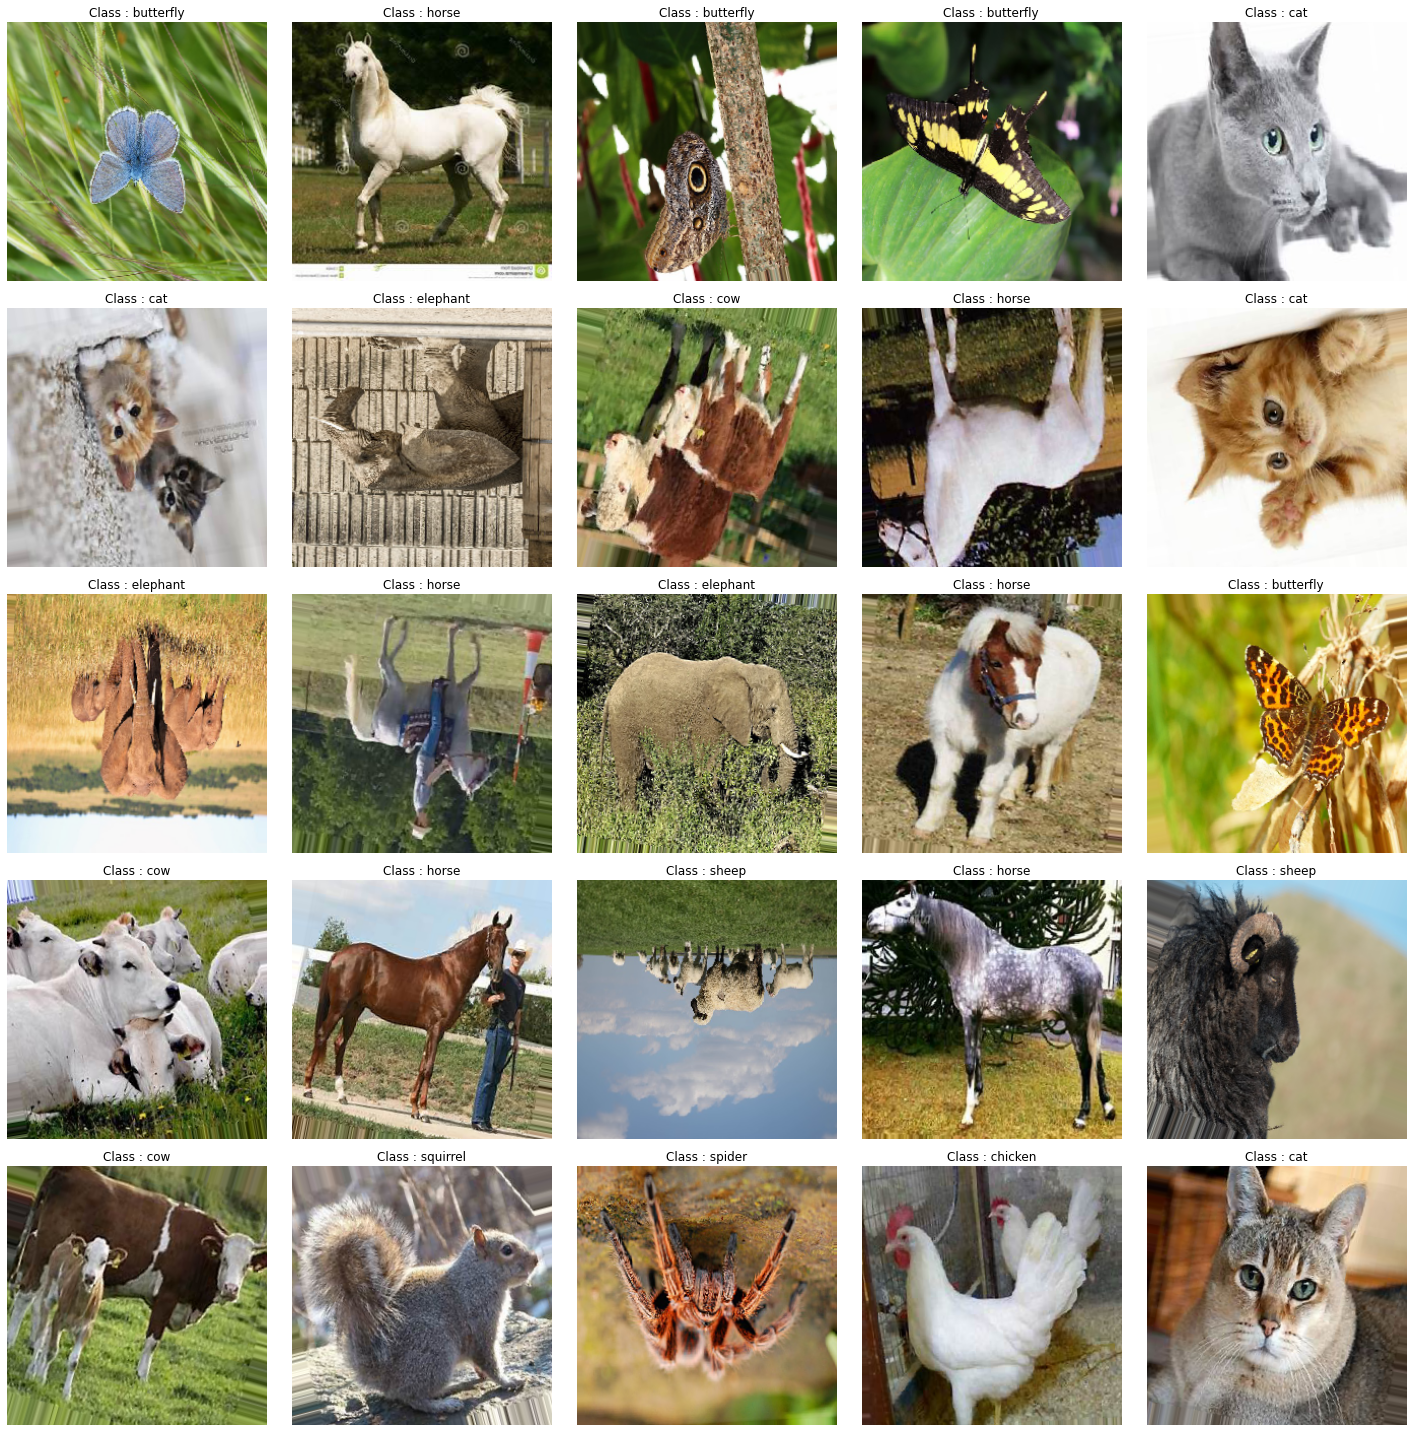

In [ ]:
plt.figure(figsize=(20,20))
i=1
for images, labels in iter(train_ds):
    
    # Get Random Image and label
    image, label = get_random_data([images, labels])
    
    # Plot it
    plt.subplot(5,5,i)
    show_image(image, title=f"Class : {class_names[int(label)]}")
    
    # Make sure to end the Loop
    i+=1
    if i>=26: break
        

plt.tight_layout()
plt.show()

In [ ]:
# Specify Model Name
name = "Xception"

 # Pretrained Model
base_model = Xception(include_top=False, input_shape=(256,256,3), weights='imagenet')
base_model.trainable = False # Freeze the Weights

 # Model 
xception = Sequential([
     base_model,
     GAP(),
     Dense(256, activation='relu'),
     Dropout(0.2),
     Dense(n_classes, activation='softmax')
 ], name=name)

 # Compile
xception.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
 )

 # Callbacks 
cbs = [
     EarlyStopping(patience=3, restore_best_weights=True),
     ModelCheckpoint(name + ".h5", save_best_only=True)
 ]

 # Train Model
hist = xception.fit(
     train_ds, validation_data=valid_ds,
     epochs=10, callbacks=cbs
 )

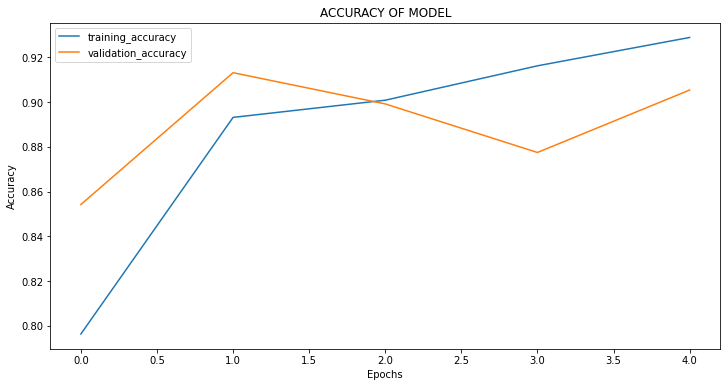

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ACCURACY OF MODEL")
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.show()

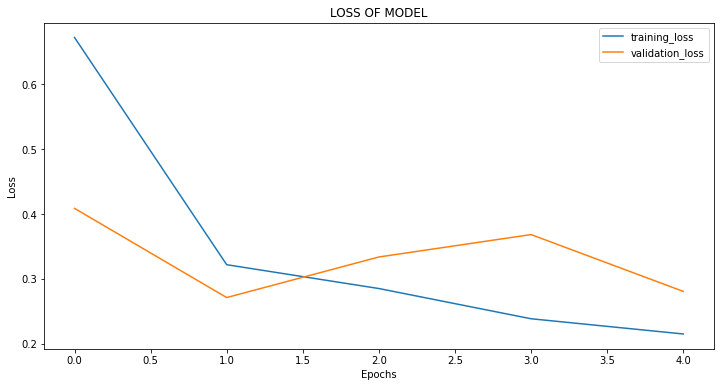

In [ ]:
# loss of our model
plt.figure(figsize=(12, 6))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LOSS OF MODEL")
plt.legend(['training_loss', 'validation_loss'])
plt.show()

In [ ]:
xception.evaluate(valid_ds) # Do it with GPU

21/21 [==============================] - 12s 563ms/step - loss: 0.2761 - accuracy: 0.9008


[0.2760862708091736, 0.9007751941680908]

1/1 [==============================] - 0s 20ms/step


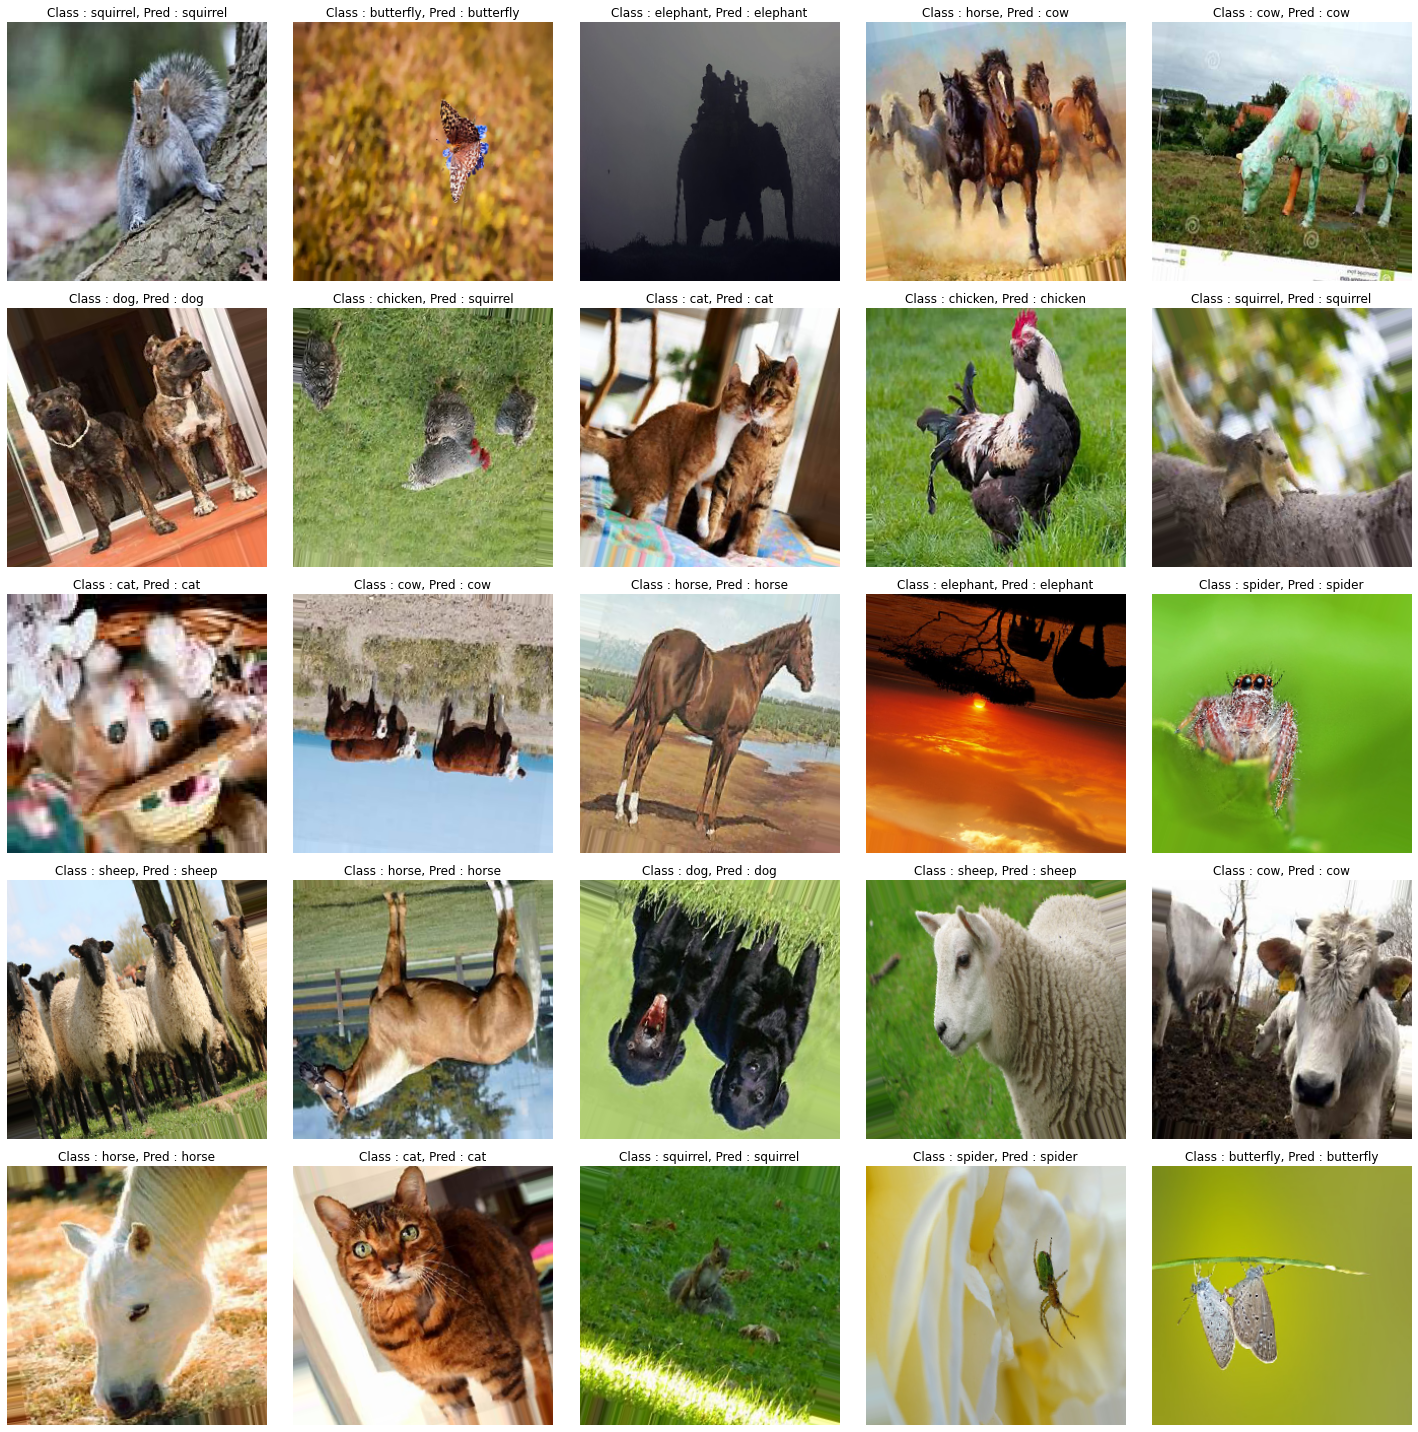

In [ ]:
#Testing the model
plt.figure(figsize=(20,20))
i=1
for images, labels in iter(valid_ds):
    
    # Get Random Image and label
    image, label = get_random_data([images, labels])
    pred_label = class_names[np.argmax(xception.predict(image[np.newaxis,...]))]
    
    # Plot it
    plt.subplot(5,5,i)
    show_image(image, title=f"Class : {class_names[int(label)]}, Pred : {pred_label}")
    
    # Make sure to end the Loop
    i+=1
    if i>=26: break
        

plt.tight_layout()
plt.show()